In [18]:

from astropy.io import fits
from operator import itemgetter
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlibinline

UsageError: Line magic function `%matplotlibinline` not found.


In [2]:
plt.style.use('ggplot')

In [4]:
image = fits.getdata('./Data/old_m82/bias_1_fixed.fits').astype(np.int32)
print(image.shape)
print('')
print(image)

(2048, 2100)

[[ 308  306 1689 ...  313  311  310]
 [ 310  304  320 ...  324  324  325]
 [ 315  316  334 ...  332  331  332]
 ...
 [ 320  319  344 ...  328  327  328]
 [ 322  316  351 ...  328  328  325]
 [ 316  319  342 ...  328  330  328]]


In [6]:
flat1 = fits.getdata('./Data/old_m82/bias_1_fixed.fits').astype(np.int32)
flat2 = fits.getdata('./Data/old_m82/bias_1_fixed.fits').astype(np.int32)
bias1 = fits.getdata('./Data/old_m82/bias_1_fixed.fits').astype(np.int32)
bias2 = fits.getdata('./Data/old_m82/bias_2_fixed.fits').astype(np.int32)

3.1366876789125656e-05


In [10]:
mean_f1 = flat1.mean()
print(mean_f1)

mean_f2 = flat2.mean()
print(mean_f2)

mean_b1 = bias1.mean()
print(mean_b1)

mean_b2 = bias2.mean()
print(mean_b2)

sigma_f1f2 = np.std(flat1 - flat2)
print(sigma_f1f2)

sigma_b1b2 = np.std(bias1 - bias2)
print(sigma_b1b2)

noise = gain * sigma_b1b2/np.sqrt(2)
print(noise.mean())

gain = ((flat1 + flat2) - (bias1 + bias2))/(sigma_f1f2 ** 2 - sigma_b1b2 **2)
print(gain.mean())

332.14769066220236
332.14769066220236
332.14769066220236
333.0896802920387
0.0
173.29555444222433
0.003843648829934236
3.1366876789125656e-05


In [14]:
noise / gain

<ipython-input-14-f460af2cd425>:1: RuntimeWarning: invalid value encountered in true_divide
  noise / gain


array([[122.5384617, 122.5384617, 122.5384617, ..., 122.5384617,
        122.5384617, 122.5384617],
       [122.5384617, 122.5384617, 122.5384617, ..., 122.5384617,
        122.5384617, 122.5384617],
       [122.5384617,         nan, 122.5384617, ..., 122.5384617,
        122.5384617, 122.5384617],
       ...,
       [122.5384617, 122.5384617, 122.5384617, ..., 122.5384617,
        122.5384617, 122.5384617],
       [122.5384617, 122.5384617, 122.5384617, ...,         nan,
        122.5384617, 122.5384617],
       [122.5384617, 122.5384617, 122.5384617, ..., 122.5384617,
        122.5384617,         nan]])

In [24]:
sigma_read = pd.DataFrame(noise / gain)
sigma_read = sigma_read.fillna(0)
sigma_read.dropna().mean()

<ipython-input-24-dd1e9e5c3e13>:1: RuntimeWarning: invalid value encountered in true_divide
  sigma_read = pd.DataFrame(noise / gain)


0       104.887658
1       105.426157
2       109.075984
3       108.657152
4       108.298152
           ...    
2095    104.349159
2096    103.750826
2097    104.229492
2098    103.391827
2099    103.631160
Length: 2100, dtype: float64

In [26]:
sub_flat1 = flat1[440:1100, 740:1400]
sub_flat2 = flat2[460:1120, 760:1420]
sub_bias1 = bias1[300:960, 400:1020]
sub_bias2 = bias2[300:960, 400:1020]

In [27]:
print(sub_flat1.shape)
print('')
print(sub_flat1)

(660, 660)

[[330 329 334 ... 328 334 330]
 [331 330 332 ... 330 331 332]
 [330 328 328 ... 329 327 330]
 ...
 [332 329 333 ... 330 328 330]
 [328 327 326 ... 332 331 327]
 [331 330 329 ... 328 330 332]]


In [28]:
sub_mean_f1 = sub_flat1.mean()
print(sub_mean_f1)

sub_mean_f2 = sub_flat2.mean()
print(sub_mean_f2)

sub_mean_b1 = sub_bias1.mean()
print(sub_mean_b1)

sub_mean_b2 = sub_bias2.mean()
print(sub_mean_b2)

sub_sigma_f1f2 = np.std(sub_flat1 - sub_flat2)
print(sub_sigma_f1f2)

sub_sigma_b1b2 = np.std(sub_bias1 - sub_bias2)
print(sub_sigma_b1b2)

330.54000688705236
330.54350321395776
330.0791397849462
329.11623900293256
23.216025152119656
17.684258688688505


In [31]:
sub_gain = ((sub_flat1 + sub_flat2) - (sub_mean_b1 +sub_mean_b2))/(sub_sigma_f1f2 ** 2 - sigma_b1b2 **2)

In [33]:
sub_read_noise = sub_gain * sub_sigma_b1b2/np.sqrt(2)
print(sub_read_noise.mean())

-0.000800561039326033


In [34]:
print('the gain in the sub region is {0:3f} e-/ADU'.format(sub_gain.mean()))

the gain in the sub region is -0.000064 e-/ADU


In [35]:
def calculate_gain(flat_1, flat_2, bias_1, bias_2):
    """
    Calculate detector gain given two flat frames and two bias frames.
    
    Parameters
    ----------
    flat_1, flat_2 : numpy.array_like
        The flat frames
    bias_1, bias_2 : numpy.array_like
        The bias frames
        
    Returns
    -------
    gain : float
        The detector gain
    """

    numerator = (np.mean(flat_1) + np.mean(flat_2)) - (np.mean(bias_1) + np.mean(bias_2))
    denominator = np.std((flat_1 - flat_2)) ** 2 - np.std((bias_1 - bias_2)) ** 2
    gain = numerator / denominator
    
    return gain

In [36]:
row_bins = np.linspace(0, flat1.shape[0], 5).astype(int)
print(row_bins)
col_bins = np.linspace(0, flat1.shape[1], 10).astype(int)
print(col_bins)

[   0  512 1024 1536 2048]
[   0  233  466  700  933 1166 1400 1633 1866 2100]


In [37]:
# This is an array to store the gain in each subregion.
gain_map = np.zeros((len(row_bins) - 1, len(col_bins - 1)))

# This nested for loop goes through each subregion.
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_slice = slice(row_bins[ii], row_bins[ii + 1])
        col_slice = slice(col_bins[jj], col_bins[jj + 1])
        
        # The `local_gain` is the gain in the subregion
        local_gain = calculate_gain(flat1[row_slice, col_slice], flat2[row_slice, col_slice],
                                    bias1[row_slice, col_slice], bias2[row_slice, col_slice])
        
        # Store the local gain in the `gain_map`
        gain_map[ii, jj] = local_gain

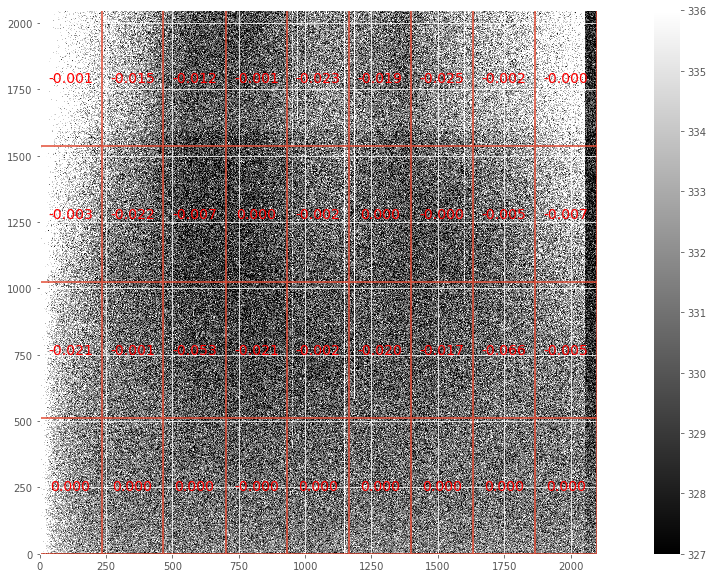

In [38]:
plt.figure(figsize=(20, 10))

# Use the imshow function to plot one of the flat images for reference.
plt.imshow(flat1, vmin=np.percentile(flat1, 5), vmax=np.percentile(flat1, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')


# Plot the boundaries of the subregions
for row in row_bins:
    plt.axhline(row)
for col in col_bins:
    plt.axvline(col)

# Print the local gain value in each subregion
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        plt.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='r')

plt.xlim(0, col_bins[-1])
plt.ylim(0, row_bins[-1])

# Add a colorbar
plt.colorbar()
plt.show()

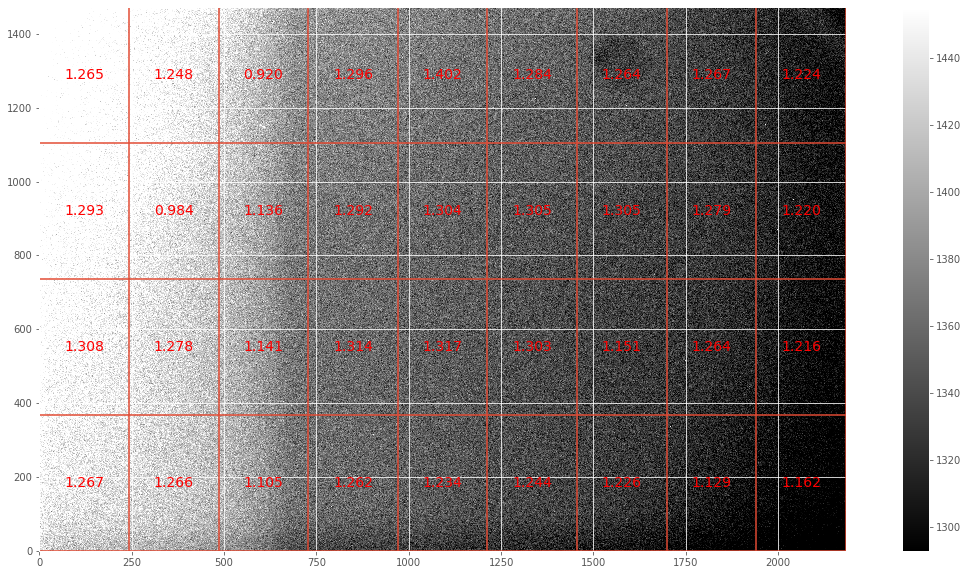

In [19]:
plt.figure(figsize=(20, 10))

# Use the imshow function to plot one of the flat images for reference.
plt.imshow(flat1, vmin=np.percentile(flat1, 5), vmax=np.percentile(flat1, 90),
           origin='lower', cmap='binary_r', interpolation='nearest')


# Plot the boundaries of the subregions
for row in row_bins:
    plt.axhline(row)
for col in col_bins:
    plt.axvline(col)

# Print the local gain value in each subregion
for ii in range(len(row_bins) - 1):
    for jj in range(len(col_bins) - 1):
        row_loc = (row_bins[ii] + row_bins[ii + 1]) / 2
        col_loc = (col_bins[jj] + col_bins[jj + 1]) / 2
        
        plt.text(col_loc, row_loc, '{:.3f}'.format(gain_map[ii, jj]),
                 ha='center', va='center', fontsize=14, color='r')

plt.xlim(0, col_bins[-1])
plt.ylim(0, row_bins[-1])

# Add a colorbar
plt.colorbar()
plt.show()

Linearity

In [27]:
import glob

In [28]:
flat_list = glob.glob('./Data/480/480_2018_.Flat*.fits')

In [29]:
print(flat_list)

['./Data/480/480_2018_.Flat.120S0X1.R.13.fits', './Data/480/480_2018_.Flat.60S0X1.R.22.fits', './Data/480/480_2018_.Flat.20S0X1.R.24.fits', './Data/480/480_2018_.Flat.45S0X1.R.26.fits', './Data/480/480_2018_.Flat.30S0X1.R.25.fits', './Data/480/480_2018_.Flat.110S0X1.R.14.fits', './Data/480/480_2018_.Flat.100S0X1.R.15.fits', './Data/480/480_2018_.Flat.10S0X1.R.23.fits', './Data/480/480_2018_.Flat.90S0X1.R.20.fits', './Data/480/480_2018_.Flat.0S0X1.R.16.fits', './Data/480/480_2018_.Flat.5S0X1.R.19.fits', './Data/480/480_2018_.Flat.1S0X1.R.18.fits', './Data/480/480_2018_.Flat.0S0X1.R.17.fits']


In [30]:
exposures = []
means = []

for filename in flat_list:
    hdu = fits.open(filename)
    
    exposure = hdu[0].header['exptime']
    print('Exposure time is {} seconds.'.format(exposure))
    
    exposures.append(exposure)
    
    mean_counts = np.mean(hdu[0].data)
    print('Mean counts: {:.2f}\n'.format(mean_counts))
    means.append(mean_counts)
    
exposures = np.array(exposures)
means = np.array(means)

times = np.argsort(exposures)
exposures = exposures[times]
means = means[times]

Exposure time is 120.0 seconds.
Mean counts: 56314.68

Exposure time is 60.0 seconds.
Mean counts: 49980.81

Exposure time is 20.0 seconds.
Mean counts: 9357.42

Exposure time is 45.0 seconds.
Mean counts: 21377.88

Exposure time is 30.0 seconds.
Mean counts: 16175.42

Exposure time is 110.0 seconds.
Mean counts: 55088.25

Exposure time is 100.0 seconds.
Mean counts: 53984.93

Exposure time is 10.0 seconds.
Mean counts: 5987.54

Exposure time is 90.0 seconds.
Mean counts: 52495.80

Exposure time is 0.5 seconds.
Mean counts: 1369.25

Exposure time is 5.0 seconds.
Mean counts: 5941.07

Exposure time is 1.0 seconds.
Mean counts: 1930.46

Exposure time is 0.2 seconds.
Mean counts: 1172.64



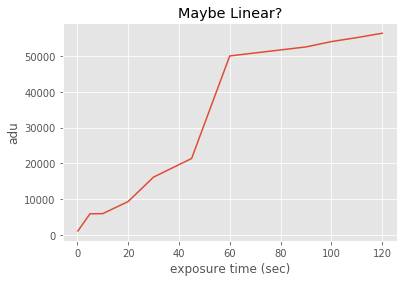

In [31]:
plt.plot(exposures, means)
plt.xlabel('exposure time (sec)')
plt.ylabel('adu')
plt.title('Maybe Linear?');

Again with sub regions!!

(I promise I tried forever trying to get a loop to do this for me but I couldn't)

In [32]:
flat1 = fits.getdata('./Data/480/480_2018_.Flat.0S0X1.R.16.fits').astype(np.int32)
flat2 = fits.getdata('./Data/480/480_2018_.Flat.0S0X1.R.17.fits').astype(np.int32)
flat3 = fits.getdata('./Data/480/480_2018_.Flat.1S0X1.R.18.fits').astype(np.int32)
flat4 = fits.getdata('./Data/480/480_2018_.Flat.5S0X1.R.19.fits').astype(np.int32)
flat5 = fits.getdata('./Data/480/480_2018_.Flat.10S0X1.R.23.fits').astype(np.int32)
flat6 = fits.getdata('./Data/480/480_2018_.Flat.20S0X1.R.24.fits').astype(np.int32)
flat7 = fits.getdata('./Data/480/480_2018_.Flat.30S0X1.R.25.fits').astype(np.int32)
flat8 = fits.getdata('./Data/480/480_2018_.Flat.45S0X1.R.26.fits').astype(np.int32)
flat9 = fits.getdata('./Data/480/480_2018_.Flat.60S0X1.R.22.fits').astype(np.int32)
flat10 = fits.getdata('./Data/480/480_2018_.Flat.90S0X1.R.20.fits').astype(np.int32)
flat11 = fits.getdata('./Data/480/480_2018_.Flat.100S0X1.R.15.fits').astype(np.int32)
flat12 = fits.getdata('./Data/480/480_2018_.Flat.110S0X1.R.14.fits').astype(np.int32)
flat13 = fits.getdata('./Data/480/480_2018_.Flat.120S0X1.R.13.fits').astype(np.int32)

sub_flat1 = flat1[1000:2180, 700:1370]
sub_flat2 = flat2[1000:2180, 700:1370]
sub_flat3 = flat3[1000:2180, 700:1370]
sub_flat4 = flat4[1000:2180, 700:1370]
sub_flat5 = flat5[1000:2180, 700:1370]
sub_flat6 = flat6[1000:2180, 700:1370]
sub_flat7 = flat7[1000:2180, 700:1370]
sub_flat8 = flat8[1000:2180, 700:1370]
sub_flat9 = flat9[1000:2180, 700:1370]
sub_flat10 = flat10[1000:2180, 700:1370]
sub_flat11 = flat11[1000:2180, 700:1370]
sub_flat12 = flat12[1000:2180, 700:1370]
sub_flat13 = flat13[1000:2180, 700:1370]

sub_flats = [sub_flat1,sub_flat2,sub_flat3,sub_flat4,sub_flat5,sub_flat6,sub_flat7,sub_flat8,sub_flat9,sub_flat10,sub_flat11,sub_flat12,sub_flat13]

exposures = np.array(exposures)
means = np.array(means)

mean0 = sub_flats[0].mean()
mean1 = sub_flats[1].mean()
mean2 = sub_flats[2].mean()
mean3 = sub_flats[3].mean()
mean4 = sub_flats[4].mean()
mean5 = sub_flats[5].mean()
mean6 = sub_flats[6].mean()
mean7 = sub_flats[7].mean()
mean8 = sub_flats[8].mean()
mean9 = sub_flats[9].mean()
mean10 = sub_flats[10].mean()
mean11 = sub_flats[11].mean()
mean12 = sub_flats[12].mean()

In [33]:
mean12

56781.68822097142

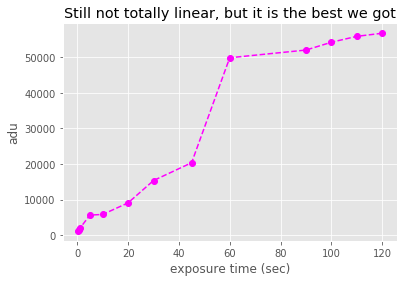

In [34]:
exposures = [.2,.5,1,5,10,20,30,45,60,90,100,110,120]
means = [mean1, mean0, mean2, mean3, mean4, mean5, mean6, mean7, mean8, mean9, mean10, mean11, mean12]
plt.plot(exposures, means, '-ko', color = 'fuchsia', linestyle = '--')
plt.xlabel('exposure time (sec)')
plt.ylabel('adu')
plt.title('Still not totally linear, but it is the best we got');

Dark Current





In [35]:
from scipy.optimize import curve_fit


T = np.array([-15., -10., -8., -6., -4.2, -2.3, 0., 2., 
                3.6, 5.8, 8.2, 10., 12.8, 16.2, 20.])
adu = np.array([13, 15, 16, 17, 19, 22, 24, 28, 32, 37, 
                43, 50, 62, 89, 139])

In [36]:
Kelvin = T +273
electrons = adu *2.3
electrons_per_sec = electrons / 120

In [37]:
k_b = 8.6175e-5

def dark_current(Kelvin, alpha, e_g):
    """
    Analytic expression for dark current as a function of temperature.
    
    Parameters
    ----------
    t_k : numpy.ndarray
        Temperature in Kelvin
    alpha : float
        Constant coefficient in front of exponential funtion.
    e_g : float
        Band gap energy in eV.
    
    Returns
    -------
    dark_current : numpy.ndarray
        Dark current in electrons/pixel/second.
    """
    dark_current = alpha * np.exp(-e_g / (2 * k_b * Kelvin))
    return dark_current

In [38]:
def normalize_data(data_array):
    result = (data_array - data_array.min()) / (data_array.max() - data_array.min())
    return result

In [39]:
t_0 = Kelvin[-1]
d_0 = electrons_per_sec[-1]

alpha_0 =  d_0 / np.exp(-1.1 / (2 * k_b * t_0))
e_g_0 = 1.1

p_opt, p_cov = curve_fit(dark_current, Kelvin, electrons_per_sec, p0=[alpha_0, e_g_0])

print(alpha_0)

7686220198.248869


In [40]:
alpha_fit, e_g_fit = p_opt

0.43233345034718706


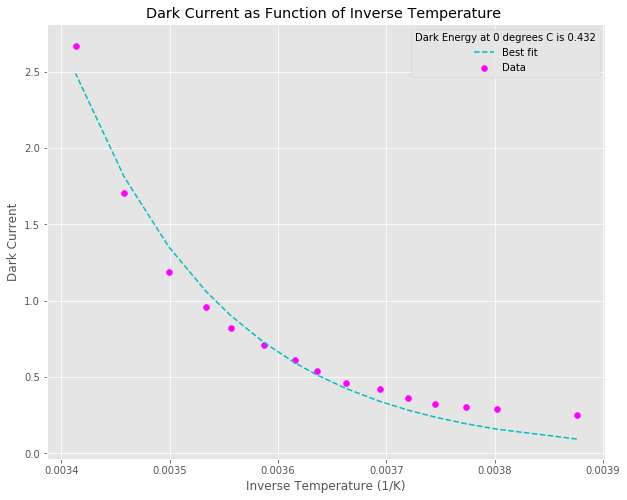

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.set_title('Dark Current as Function of Inverse Temperature ') 
ax.set_xlabel('Inverse Temperature (1/K)')
ax.set_ylabel('Dark Current')

ax.plot(Kelvin**-1,dark_current(Kelvin, alpha_fit, e_g_fit), label = 'Best fit', linestyle = '--', color = 'c')
#plot data
ax.scatter(Kelvin**-1,electrons_per_sec, label = 'Data', color = 'magenta')
d_at_0 = dark_current(273.2, alpha_fit, e_g_fit)
print(d_at_0)
#ax.plot(fitted, t_k)
ax.legend(title='Dark Energy at 0 degrees C is {0:.3f}'.format(d_at_0));

In [42]:
DC_low = dark_current(273, alpha_fit, e_g_fit)

In [43]:
DC_low

0.42424975594088105